In [33]:
import pandas as pd
import numpy as np
dirty_data_priora = pd.read_csv('C:\\Users\\Lo_Sci\\Desktop\\Py\\Prio\\Priora_List1.csv')

# подготавливаем цифровые данные
priora_only_input = dirty_data_priora[['дата', 'часы в пути', 'минуты в пути', 'пробег', 'средний расход', 
                                       'температура', 'маршрут', 'топливо', 'откуда', 'до куда']]
priora_num = priora_only_input.rename(columns={'часы в пути': 'hours', 'маршрут': 'km', 'минуты в пути':'minutes'})
priora_num['temperature'] = pd.to_numeric(priora_num['температура'].str.replace(',','.'), errors='coerce')
priora_num['path'] = pd.to_numeric(priora_num['km'].str.replace(',','.'), errors='coerce')
priora_num['hrs'] = priora_num.hours + priora_num.minutes/60
priora_num['fuel'] = pd.to_numeric(priora_num['топливо'].str.replace(',','.'), errors='coerce')
priora_num['time_h'] = np.diff(priora_num.hrs, prepend=0)
priora_num['benz'] = np.diff(priora_num.fuel, prepend=0)
priora_num['distance'] = np.diff(priora_num.path, prepend=0)
priora_num['av_speed'] = priora_num.distance / priora_num.time_h
priora_num['rashod'] = 100 * priora_num.benz / priora_num.distance

priora_num.drop(columns=['откуда', 'до куда']).head()

# отфильтровываем неразумные данные и исключаем нечисловые (вспомогательные информационные) колонки
priora_detailsfree = priora_num[['temperature', 'distance', 'time_h', 'benz', 'av_speed', 'rashod']] \
                    .query('distance > 3 & time_h > 0 & rashod < 50')
priora_detailsfree.head()

,temperature,distance,time_h,benz,av_speed,rashod
2,2.0,32.8,0.633333,2.8,51.789474,8.536585
4,1.0,35.6,0.666667,2.3,53.400000,6.460674
5,24.0,366.2,16.066667,37.2,22.792531,10.158383
6,24.0,5.3,0.083333,0.4,63.600000,7.547170
7,24.0,66.2,1.283333,4.8,51.584416,7.250755


In [34]:
# высчитываем глобальные величины по всей базе
global_sr_ras = 100 * priora_detailsfree.benz.sum() / priora_detailsfree.distance.sum()
global_sr_skor = priora_detailsfree.distance.sum() / priora_detailsfree.time_h.sum()
print(
        'средняя скорось за все время эксплуатации = ', round(global_sr_skor, 2),
        'км/ч, при среднем расходе', round(global_sr_ras, 2), 'л/100км'
     )

средняя скорось за все время эксплуатации =  24.76 км/ч, при среднем расходе 9.82 л/100км


<AxesSubplot:>

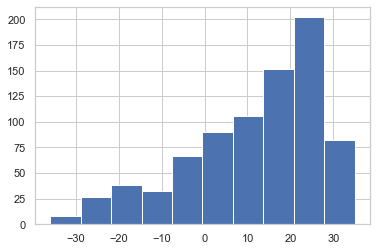

In [37]:
# можно посмотреть распределение количества наблюдейний от температуры
priora_detailsfree.temperature.hist()

<AxesSubplot:xlabel='temperature'>

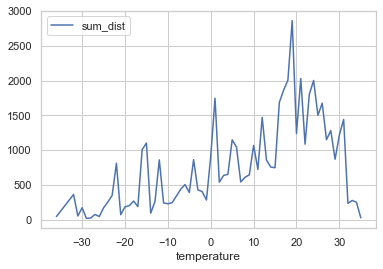

In [38]:
# можно посмотреть суммарную дистанцию, пройденную при разных температурах
priora_detailsfree.groupby('temperature', as_index=False).agg({'distance': 'sum'}). \
    rename(columns={'distance':'sum_dist'}). \
    plot(x='temperature', y='sum_dist')

In [39]:
# разобъем данные на 5 диапозонов температуры
priora_detailsfree['temp_range'] = pd.cut(priora_detailsfree.temperature, 5, \
                                          labels=["very cold", "cold", "medium", "hot", "very hot"])
priora_detailsfree.head()

,temperature,distance,time_h,benz,av_speed,rashod,temp_range
2,2.0,32.8,0.633333,2.8,51.789474,8.536585,medium
4,1.0,35.6,0.666667,2.3,53.400000,6.460674,medium
5,24.0,366.2,16.066667,37.2,22.792531,10.158383,very hot
6,24.0,5.3,0.083333,0.4,63.600000,7.547170,very hot
7,24.0,66.2,1.283333,4.8,51.584416,7.250755,very hot


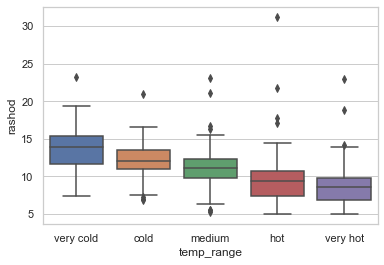

In [45]:
# теперь можно сравнить распределение наблюдений при разных температурах
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="temp_range", y="rashod", data=priora_detailsfree)

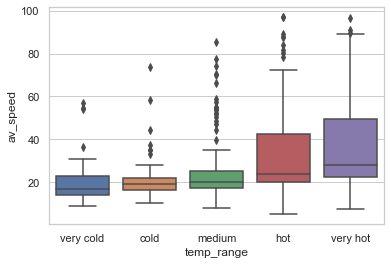

In [46]:
# при высоких тепературах диапазон скоростей выше и заметно шире
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="temp_range", y="av_speed", data=priora_detailsfree)

In [41]:
# делаем запрос и агреггируем все показания при одинаковых температурах
priora_temperature = priora_detailsfree.groupby(['temperature'], as_index=False) \
    .agg({'distance':'sum', 'benz':'sum', 'time_h':'sum'})
priora_temperature['t_rashod'] = 100 * priora_temperature.benz / priora_temperature.distance
priora_temperature.head()

,temperature,distance,benz,time_h,t_rashod
0,-36.0,47.8,9.2,4.300000,19.246862
1,-32.0,364.8,53.8,23.900000,14.747807
2,-31.0,56.0,7.9,3.266667,14.107143
3,-30.0,173.9,28.7,13.383333,16.503738
4,-29.0,21.7,4.2,1.750000,19.354839


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.05, 0.95, '$y=-0.104\\;x+11.213$\n$R^2 = 0.704$')

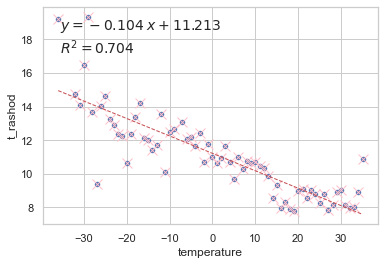

In [42]:
# линейная ререссия
import matplotlib.pyplot as plt
priora_temperature.plot.scatter(x='temperature', y='t_rashod')
from sklearn.metrics import r2_score

x = priora_temperature.temperature
y = priora_temperature.t_rashod

plt.plot(x,y,"x", ms=10, mec="pink")
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.05, 0.95, '$y=0.001\\;x^2-0.106\\;x+10.751$\n$R^2 = 0.731$')

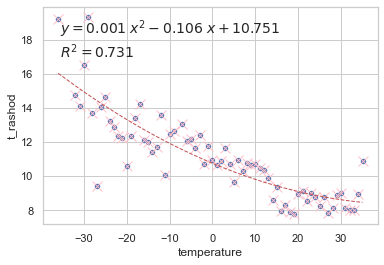

In [43]:
# ререссия квадратичной функцией
import matplotlib.pyplot as plt
priora_temperature.plot.scatter(x='temperature', y='t_rashod')
from sklearn.metrics import r2_score

x = priora_temperature.temperature
y = priora_temperature.t_rashod

plt.plot(x,y,"x", ms=10, mec="pink")
z = np.polyfit(x, y, 2)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x^2{z[1]:0.3f}\;x{z[2]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

In [48]:
# для регрессии подходит квадратичная зависимость расхода от температуры, но необходимо учитывать,
# что средняя скорость при низких температурах ниже

<AxesSubplot:xlabel='av_speed', ylabel='rashod'>

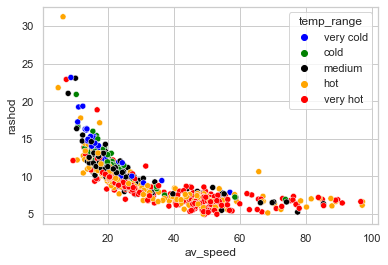

In [49]:
# данные с низкой температурой собраны в левой части зависимости от скорости
import seaborn as sns
sns.scatterplot(x='av_speed', y='rashod', hue='temp_range', data=priora_detailsfree, 
                palette={'very cold': 'blue', 'cold': 'green', 'medium': 'black', 'hot': 'orange', 'very hot': 'red'},
               )

In [54]:
# можно оценить стат.значимость отличий распределений в разных температурных диапазонах
from scipy.stats import ttest_ind
ttest_ind(
    priora_detailsfree[priora_detailsfree.temp_range == "very hot"].rashod, 
    priora_detailsfree[priora_detailsfree.temp_range == "hot"].rashod
)

Ttest_indResult(statistic=-4.27729613776377, pvalue=2.2382755455232242e-05)